# Import package

In [1]:
library(forecast)

Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


# Load dataset

In [2]:
data <- read.csv('Data.csv')

In [3]:
summary(data)

      Date            Mkt.RF              SMB                HML         
 Min.   :196307   Min.   :-23.2400   Min.   :-15.3900   Min.   :-13.920  
 1st Qu.:197803   1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -1.395  
 Median :199212   Median :  0.9250   Median :  0.1050   Median :  0.230  
 Mean   :199248   Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.300  
 3rd Qu.:200708   3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.700  
 Max.   :202204   Max.   : 16.1000   Max.   : 18.3800   Max.   : 12.740  
      RMW                CMA                RF             NoDur        
 Min.   :-18.7600   Min.   :-6.7800   Min.   :0.0000   Min.   :-21.020  
 1st Qu.: -0.8175   1st Qu.:-1.0000   1st Qu.:0.1400   1st Qu.: -1.242  
 Median :  0.2400   Median : 0.1100   Median :0.3800   Median :  1.080  
 Mean   :  0.2752   Mean   : 0.2947   Mean   :0.3641   Mean   :  1.049  
 3rd Qu.:  1.2775   3rd Qu.: 1.4900   3rd Qu.:0.5100   3rd Qu.:  3.720  
 Max.   : 13.3800   Max.   : 9.0600   Max.  

# Train & Predict

#### Lấy dữ liệu

In [4]:
series <- ts(data = data$Other, start = c(1963,7), end = c(2022,4), frequency = 12)
X <- ts(data = data[,2:7], start = c(1963,7), end = c(2022,4), frequency = 12)[,-3]

In [5]:
series %>% summary()

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-23.6000  -2.0400   1.3650   0.9452   4.1250  20.2400 

In [6]:
X %>% summary()

     Mkt.RF              SMB                RMW                CMA         
 Min.   :-23.2400   Min.   :-15.3900   Min.   :-18.7600   Min.   :-6.7800  
 1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -0.8175   1st Qu.:-1.0000  
 Median :  0.9250   Median :  0.1050   Median :  0.2400   Median : 0.1100  
 Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.2752   Mean   : 0.2947  
 3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.2775   3rd Qu.: 1.4900  
 Max.   : 16.1000   Max.   : 18.3800   Max.   : 13.3800   Max.   : 9.0600  
       RF        
 Min.   :0.0000  
 1st Qu.:0.1400  
 Median :0.3800  
 Mean   :0.3641  
 3rd Qu.:0.5100  
 Max.   :1.3500  

#### Khảo sát tập train từ 7/1963 - 12/1989

In [7]:
log_scale <- function(x) {log(1+x/100)} #scaler
log_inv <- function(x) {(exp(x)-1)*100} #inverter

In [8]:
series_train <- series %>% window(end=c(1989,12)) %>% log_scale()
X_train <- X %>% window(end=c(1989,12)) %>% log_scale()

In [9]:
series_train %>% summary()

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.269187 -0.018673  0.012719  0.008626  0.043586  0.184320 

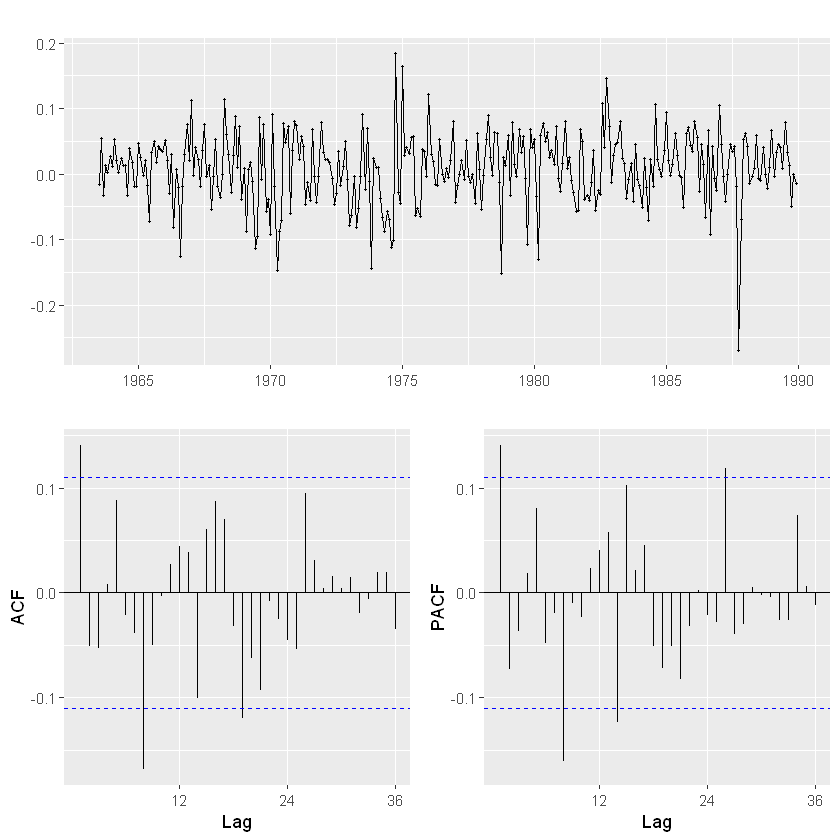

In [10]:
series_train %>% ggtsdisplay()

#### Chọn tham số cho mô hình Dynamic

In [11]:
auto.arima(y = series_train, xreg = X_train, stepwise = FALSE, approximation = FALSE)

Series: series_train 
Regression with ARIMA(0,0,1) errors 

Coefficients:
         ma1  Mkt.RF     SMB      RMW      CMA      RF
      0.1781  1.0544  0.2281  -0.3411  -0.1314  1.1418
s.e.  0.0561  0.0183  0.0274   0.0614   0.0531  0.1534

sigma^2 estimated as 0.0001772:  log likelihood=925.27
AIC=-1836.54   AICc=-1836.18   BIC=-1810.2

In [12]:
fit <- Arima(y = series_train, xreg = X_train, order = c(0,0,1))

In [13]:
fitted <- ts(data = fit$fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
true <- ts(data = fit$x, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv

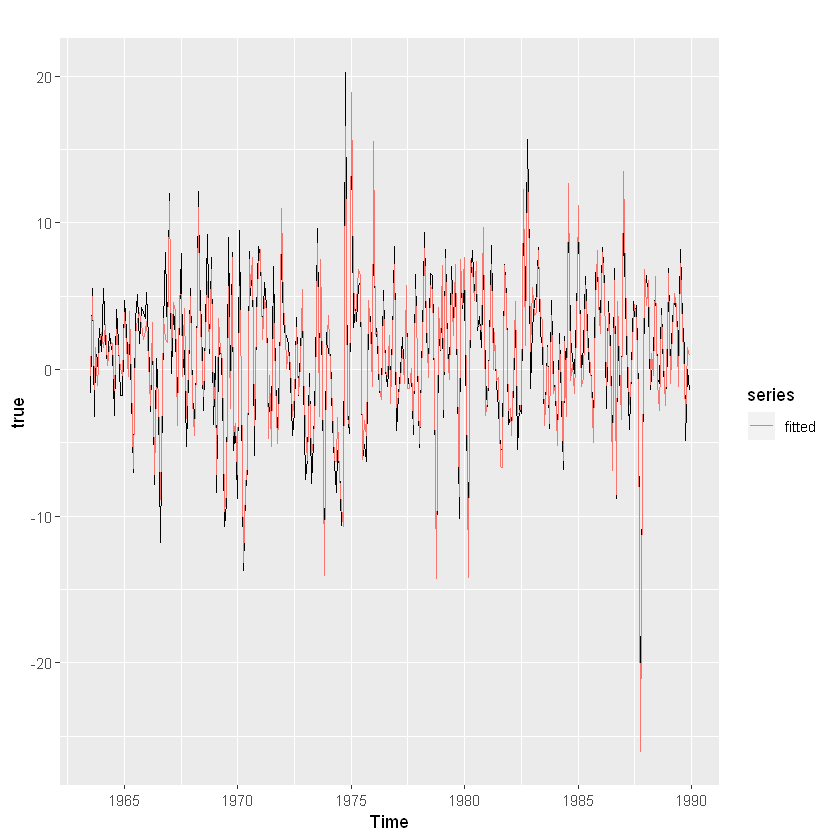

In [14]:
autoplot(true)+autolayer(fitted)

In [15]:
(true - fitted)^2 %>% mean %>% sqrt

[1] 1.332222

#### Chạy thử một số bộ ARIMA trên tập train

In [16]:
order <- list(ARIMA000 = c(0,0,0), ARIMA001 = c(0,0,1), ARIMA002 = c(0,0,2), ARIMA003 = c(0,0,3),
              ARIMA100 = c(1,0,0), ARIMA101 = c(1,0,1), ARIMA102 = c(1,0,2), ARIMA103 = c(1,0,3),
              ARIMA200 = c(2,0,0), ARIMA201 = c(2,0,1), ARIMA202 = c(2,0,2), ARIMA203 = c(2,0,3))

In [17]:
result <- NULL
for (o in order)
{
    fit <- Arima(y = series_train, xreg = X_train, order = o)
    fitted <- ts(data = fit$fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
    rmse <- sqrt(mean((log_inv(series_train) - fitted)^2))
    result <- rbind(result, c(AIC = fit$aic, AICc = fit$aicc, BIC = fit$bic, RMSE = rmse))
}
row.names(result) <- names(order)
result

,AIC,AICc,BIC,RMSE
ARIMA000,-1829.641,-1829.280,-1803.307,1.350884
ARIMA001,-1836.580,-1836.114,-1806.483,1.332222
ARIMA002,-1834.714,-1834.130,-1800.856,1.331734
ARIMA003,-1836.035,-1835.318,-1798.414,1.325515
ARIMA100,-1835.681,-1835.215,-1805.585,1.334316
ARIMA101,-1834.636,-1834.052,-1800.778,1.332010
ARIMA102,-1835.755,-1835.038,-1798.135,1.324961
ARIMA103,-1835.274,-1834.412,-1793.892,1.322109
ARIMA200,-1835.759,-1835.175,-1801.901,1.329457
ARIMA201,-1836.755,-1836.038,-1799.134,1.322695


#### Predict & đánh giá RMSE

In [21]:
pred <- NULL
for (i in 0:387)
{
    train <- series %>% subset(end=length(series)-388+i) %>% log_scale()
    reg <- X %>% subset(end=length(series)-388+i) %>% log_scale()
    fit <- Arima(y = train, xreg = reg, order = c(2,0,2))
    newreg <- X %>% subset(start=length(series)-387+i, end=length(series)-387+i) %>% log_scale()
    pred_val <- forecast(fit, h = 1, xreg = newreg)$mean %>% log_inv()
    pred <- c(pred, pred_val)
}
pred <- ts(pred, start=c(1990,1), frequency = 12)
true <- series %>% window(start=c(1990,1))
rmse <- sqrt(mean((true-pred)^2))

In [22]:
rmse

[1] 2.351218

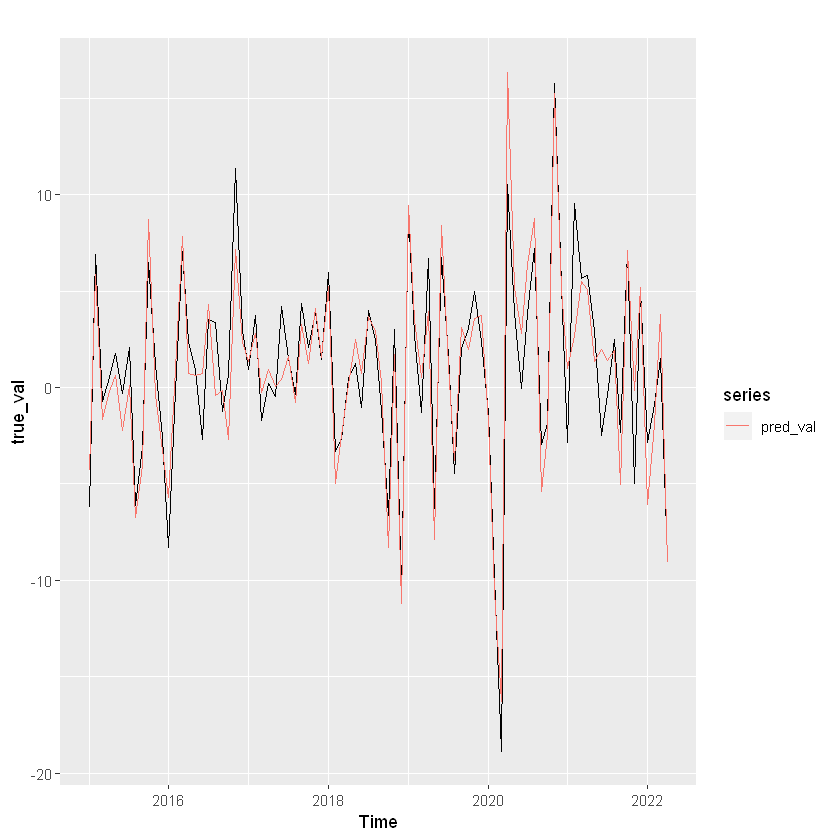

In [20]:
true_val <- true %>% window(start = c(2015,1))
pred_val <- pred %>% window(start = c(2015,1))
autoplot(true_val) + autolayer(pred_val)